In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import shutil

In [2]:
if not os.path.isdir("valid"):
    path = "valid"
    os.mkdir(path)
    for i in range(43):
        os.mkdir(os.path.join(path, str(i)))

In [3]:
file_num =[]
for i in range(43):
    onlyfiles = next(os.walk("Images/{}".format(i)))[2] 
    file_num.append(len(onlyfiles))
if not os.path.isdir("valid"):
    for i in range(43):
        source = "Images/{}".format(i)
        des = "valid/{}".format(i)
        imgs= os.listdir(source)
        for file_name in random.sample(imgs, int(file_num[i]*0.1)):
            shutil.move(os.path.join(source, file_name), des)

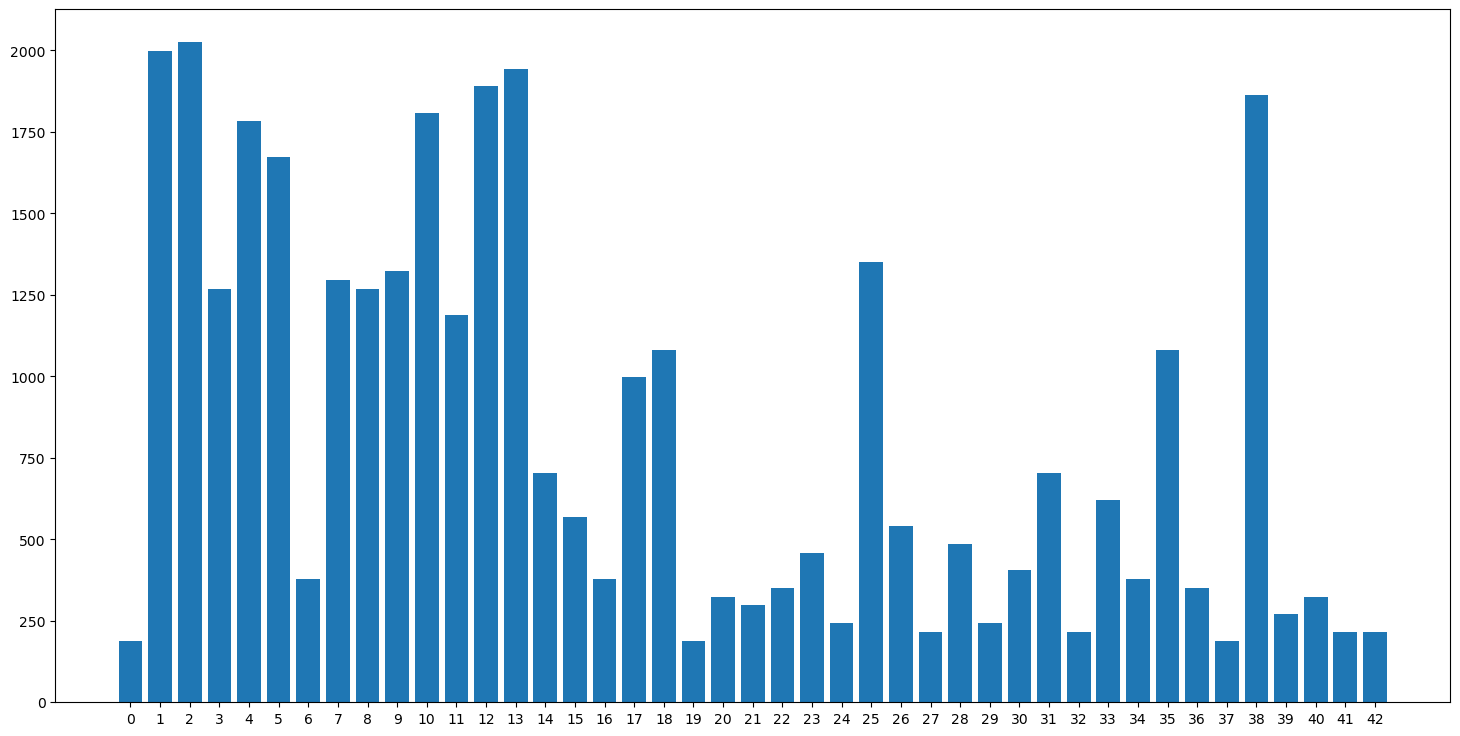

In [4]:
Xticks = [i for i in range(43)]
plt.bar(Xticks, file_num)
plt.xticks(Xticks)
plt.rcParams['figure.figsize'] = 18, 9
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
gen=ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_batches = gen.flow_from_directory("Images", target_size=(60, 60), class_mode = "sparse")
valid_batches = gen.flow_from_directory("valid", target_size=(60, 60), class_mode = "sparse")

Found 35289 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.


In [6]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_batches.labels), 
                                                  train_batches.labels)
class_weights_dict = {i:v for i, v in enumerate(class_weights)}

C:\Users\www\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42], y=[ 0  0  0 ... 42 42 42] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [7]:
class_weights_dict

{0: 4.342192691029901,
 1: 0.4107479572595852,
 2: 0.45366192294342245,
 3: 0.6908033826638478,
 4: 0.43421926910299,
 5: 0.4221576227390181,
 6: 1.1690518783542039,
 7: 1.4473975636766334,
 8: 2.1710963455149503,
 9: 0.8214959145191704,
 10: 0.7598837209302326,
 11: 4.342192691029901,
 12: 0.40527131782945736,
 13: 2.5329457364341086,
 14: 2.763213530655391,
 15: 2.3381037567084078,
 16: 1.7879616963064295,
 17: 3.3772609819121446,
 18: 0.607906976744186,
 19: 1.5197674418604652,
 20: 3.7994186046511627,
 21: 1.6886304909560723,
 22: 3.3772609819121446,
 23: 0.6467095497278575,
 24: 2.026356589147287,
 25: 1.1690518783542039,
 26: 3.7994186046511627,
 27: 1.321536905965622,
 28: 2.1710963455149503,
 29: 0.7598837209302326,
 30: 2.3381037567084078,
 31: 4.342192691029901,
 32: 0.44051230198854063,
 33: 3.0395348837209304,
 34: 0.4605355884425652,
 35: 2.5329457364341086,
 36: 3.7994186046511627,
 37: 3.7994186046511627,
 38: 0.49024756189047264,
 39: 2.1710963455149503,
 40: 0.63323643

In [8]:
class_indices = train_batches.class_indices
class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '5': 38,
 '6': 39,
 '7': 40,
 '8': 41,
 '9': 42}

In [9]:
base_model=tf.keras.applications.EfficientNetB2(include_top=False,input_shape=(60,60,3), pooling='max') 

In [10]:
from tensorflow.keras import regularizers
optimizer = tf.keras.optimizers.Nadam(0.001)
x=base_model.output
x=keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=keras.layers.Dropout(rate=.45, seed=123)(x)        
output=keras.layers.Dense(43, activation='softmax')(x)
model=keras.Model(inputs=base_model.input, outputs=output)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 60, 60, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 60, 60, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 61, 61, 3)    0           normalization[0][0]              
______________________________________________________________________________________________

In [12]:
optimizer = tf.keras.optimizers.Nadam(0.001)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
history = model.fit(x=train_batches,
                    steps_per_epoch=len(train_batches)/32,
                    validation_data=valid_batches,
                    validation_steps=len(valid_batches)/32,
                    epochs=20,
                    callbacks = [ROP],
                    class_weight = class_weights_dict
)

Epoch 1/20
34/34 [==============================] - 58s 833ms/step - loss: 11.4696 - accuracy: 0.0938 - val_loss: 10.2002 - val_accuracy: 0.1875
Epoch 2/20
34/34 [==============================] - 28s 797ms/step - loss: 9.8187 - accuracy: 0.2455 - val_loss: 10.2963 - val_accuracy: 0.2266
Epoch 3/20
34/34 [==============================] - 27s 763ms/step - loss: 8.3439 - accuracy: 0.3420 - val_loss: 7.6456 - val_accuracy: 0.4219
Epoch 4/20
34/34 [==============================] - 26s 755ms/step - loss: 7.0933 - accuracy: 0.4411 - val_loss: 6.8568 - val_accuracy: 0.5078
Epoch 5/20
34/34 [==============================] - 27s 768ms/step - loss: 6.1929 - accuracy: 0.4964 - val_loss: 6.0952 - val_accuracy: 0.5312
Epoch 6/20
34/34 [==============================] - 30s 851ms/step - loss: 5.5342 - accuracy: 0.5616 - val_loss: 5.5837 - val_accuracy: 0.5469
Epoch 7/20
34/34 [==============================] - 26s 751ms/step - loss: 4.7101 - accuracy: 0.6536 - val_loss: 4.5841 - val_accuracy: 0.7

In [13]:
optimizer = tf.keras.optimizers.Nadam(0.0005)
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
history = model.fit(x=train_batches,
                    steps_per_epoch=len(train_batches)/32,
                    validation_data=valid_batches,
                    validation_steps=len(valid_batches)/32,
                    epochs=20,
                    callbacks = [ROP],
                    class_weight = class_weights_dict
)

Epoch 1/20
34/34 [==============================] - 62s 830ms/step - loss: 0.9668 - accuracy: 0.9277 - val_loss: 0.7902 - val_accuracy: 0.9453
Epoch 2/20
34/34 [==============================] - 28s 803ms/step - loss: 0.8027 - accuracy: 0.9411 - val_loss: 0.7159 - val_accuracy: 0.9688
Epoch 3/20
34/34 [==============================] - 27s 790ms/step - loss: 0.7924 - accuracy: 0.9464 - val_loss: 0.6627 - val_accuracy: 0.9688
Epoch 4/20
34/34 [==============================] - 29s 835ms/step - loss: 0.7311 - accuracy: 0.9411 - val_loss: 0.6185 - val_accuracy: 0.9766
Epoch 5/20
34/34 [==============================] - 28s 800ms/step - loss: 0.8379 - accuracy: 0.9348 - val_loss: 0.7096 - val_accuracy: 0.9609
Epoch 6/20
34/34 [==============================] - 27s 767ms/step - loss: 0.7782 - accuracy: 0.9277 - val_loss: 0.6696 - val_accuracy: 0.9844
Epoch 7/20
34/34 [==============================] - 27s 762ms/step - loss: 0.7373 - accuracy: 0.9330 - val_loss: 0.6249 - val_accuracy: 0.9922

In [14]:
model.save("problem2_model")

INFO:tensorflow:Assets written to: problem2_model\assets


C:\Users\www\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
